# Relatório de Análise Exploratória – Alfabetização de Mulheres no Brasil (Censo 2022 & INEP 2022)

## **1. Introdução**

Neste relatório, demonstro a aplicação prática dos dados obtidos através de um projeto de extração (ETL) que desenvolvi e disponibilizei no GitHub.

Optei por analisar os dados sob o viés da **alfabetização** por considerar este um indicador relevante para compreender o desenvolvimento humano e social. A educação é uma ferramenta essencial para entender a sociedade, orientar políticas públicas e revelar padrões regionais.

Nesta análise exploratória, investigo as declarações do Censo 2022 sobre alfabetização no Brasil, com um foco específico no recorte de gênero.

A pergunta central que guia a minha análise é:
**Quantas mulheres se autodeclararam alfabetizadas no Brasil em comparação aos homens?**

Para responder a esta questão, utilizei:
* **Censo Demográfico 2022 (IBGE):** para quantificar homens e mulheres adultos alfabetizados por município e Unidade Federativa (UF).
* **Censo Escolar 2022 (INEP):** para analisar matrículas associadas ao processo de alfabetização (anos iniciais do fundamental e EJA fundamental), também segmentadas por sexo e UF.

O meu objetivo final é identificar se existem desigualdades de género, como estas diferenças variam entre estados e municípios, e de que forma se relacionam com o fluxo educacional captado pelo INEP.

## **2. Fontes de Dados**

Para este estudo, utilizei os dados que extraí e tratei no seguinte projeto:
> [ETL Censo BigQuery - Mulheres Brasil](https://github.com/patriciacarbri/etl-censo-bigquery-mulheres-brasil)

### **2.1. Censo 2022 (Censo Demográfico – IBGE)**
* **Nível de agregação:** Município.
* **População:** Padrão **autodeclarativo** do Censo.
* **Definição de Alfabetização:** Resposta afirmativa à pergunta "Sabe ler e escrever?".
* **Variáveis relevantes selecionadas:**
    * Geografia: `id_municipio`, `nome_municipio`, `sigla_uf`
    * Demografia: `populacao_homens`, `populacao_mulheres`, `populacao_total`

---

### **2.2. INEP 2022 (Censo Escolar)**
Utilizei esta fonte para examinar as matrículas em níveis de ensino associados ao processo de alfabetização:
* **QT_MAT_FUND_AI:** Matrículas nos anos iniciais do ensino fundamental.
* **QT_MAT_EJA_FUND:** Matrículas da EJA (Educação de Jovens e Adultos) no nível fundamental.
* **Matrículas por sexo:** `QT_MAT_BAS_FEM` e `QT_MAT_BAS_MASC`.
* **Variáveis geográficas:** `id_municipio`, `SG_UF`, `NO_UF`.

O cruzamento destes dados permite-me observar se o padrão de alfabetização autodeclarado se reflete também nas matrículas escolares formais.

---

## **3. Metodologia**

### **Critérios adotados**
* **População analisada:** Baseada inteiramente na declaração no Censo 2022.
* **Unificação das bases (Censo–INEP):** Realizada através da chave `id_municipio`.
* **Filtros:** Não apliquei filtros adicionais (como escolaridade mínima) para manter a aderência estrita à métrica oficial de alfabetização do IBGE.

### **Indicadores calculados**
Durante a análise, construí os seguintes indicadores:
* Taxa de alfabetização feminina por UF.
* Taxa de alfabetização masculina por UF.
* **Gap de género:** Diferença entre a `taxa_mulheres` e a `taxa_homens`.
* Comparação entre alfabetização (stock/Censo) e matrículas (fluxo/INEP).
* Detalhamento dos dados a nível municipal.

In [27]:
# 1. Bibliotecas necessárias
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import stats

In [ ]:
# 2. Configurações de diretórios e caminhos
"""
Conforme o informado, os dados aqui usados são de uma camada "confiável" (trusted), extraído por outro projeto que criou 
uma pipeline de extração e tratamento dos dados. Disponível em:
  > https://github.com/patriciacarbri/etl-censo-bigquery-mulheres-brasil.

"""
PATH_BQ = "data/censo_2022_trusted.parquet"
PATH_INEP = "data/inep_2022_trusted.parquet"
OUT_DIR = "data/analysis_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

In [ ]:
# 3. Carregamento dos dados
print('Carregando arquivos...')

df_censo = pd.read_parquet(PATH_BQ)
df_inep = pd.read_parquet(PATH_INEP)


print('Arquivos carregados:')
print('Censo (df_censo):', df_censo.shape)
print('INEP (df_inep):', df_inep.shape)


Carregando arquivos...
Arquivos carregados:
Censo (df_censo): (779800, 8)
INEP (df_inep): (178346, 32)
SIDRA 2010 (df_sidra): (5565, 5)


In [4]:
# Apresentação da colunas dos dados extraídos:

print('\nColunas principais do Censo (bq):')
print(df_censo.columns.tolist())


print('\nColunas principais do INEP (df_inep):')
print(df_inep.columns.tolist()[:50])


print('\nColunas principais do SIDRA:')
print(df_sidra.columns.tolist()[:50])


Colunas principais do Censo (bq):
['id_municipio', 'nome_municipio', 'sigla_uf', 'sexo', 'cor_raca', 'grupo_idade', 'alfabetizacao', 'populacao']

Colunas principais do INEP (df_inep):
['NU_ANO_CENSO', 'NO_REGIAO', 'CO_REGIAO', 'NO_UF', 'SG_UF', 'CO_UF', 'NO_MUNICIPIO', 'id_municipio', 'QT_MAT_BAS', 'QT_MAT_INF', 'QT_MAT_INF_CRE', 'QT_MAT_INF_PRE', 'QT_MAT_FUND', 'QT_MAT_FUND_AI', 'QT_MAT_FUND_AF', 'QT_MAT_MED', 'QT_MAT_PROF', 'QT_MAT_PROF_TEC', 'QT_MAT_EJA', 'QT_MAT_EJA_FUND', 'QT_MAT_EJA_MED', 'QT_MAT_ESP', 'QT_MAT_ESP_CC', 'QT_MAT_ESP_CE', 'QT_MAT_BAS_FEM', 'QT_MAT_BAS_MASC', 'QT_MAT_BAS_ND', 'QT_MAT_BAS_BRANCA', 'QT_MAT_BAS_PRETA', 'QT_MAT_BAS_PARDA', 'QT_MAT_BAS_AMARELA', 'QT_MAT_BAS_INDIGENA']

Colunas principais do SIDRA:
['id_municipio', 'municipio', 'ano', 'sexo', 'valor']


Ao explorar os dados extraídos do Censo, identifiquei que estes oferecem um perfil demográfico completo, permitindo cruzamentos por sexo, grupo de idade, cor/raça e a própria autodeclaração de alfabetização.

Por outro lado, os dados do INEP apresentam uma granularidade distinta, focada no volume e tipologia das matrículas. Visto que o meu estudo se concentra na alfabetização, filtrei e utilizei apenas as colunas do Censo Escolar que representam diretamente esta etapa de ensino, descartando variáveis que não contribuiriam para a resposta da minha pergunta central.

Padronização mínima dos dados

> Como os dados já estão em formato "trusted" neste notebook serão aplicadas somente padronizações mínimas necessárias para a análise.

In [5]:
# Nomes de colunas padronizados:

# Padronização de nomes de colunas do Inep
df_inep = df_inep.rename(columns={
    'sg_uf': 'sigla_uf',
    'NO_MUNICIPIO': 'nome_municipio'})

# Garantir id_municipio como string 
for d in (df_censo, df_inep, df_sidra):
    if 'id_municipio' in d.columns:
        d['id_municipio'] = d['id_municipio'].astype(str)


### **CAPÍTULO 1 — Panorama geral da alfabetização feminina no Brasil**

Perguntas que você definiu:

1. **Qual é a distribuição da alfabetização feminina no Brasil em 2022?**
2. **Como a alfabetização feminina varia entre UFs ?**
3. **Quais capitais concentram os maiores e menores índices de alfabetização entre mulheres?**
 

**Objetivo do capítulo:**
Criar o retrato inicial. Gráficos + mapas.

#### **Como é distribuída a população feminina alfabetizada por raça dentro dos municípios e capitais?**

In [ ]:
# 1) Dicionário de capitais (inclui DF)
capitais = {
    "Rio Branco": "AC", "Maceió": "AL", "Macapá": "AP", "Manaus": "AM",
    "Salvador": "BA", "Fortaleza": "CE", "Brasília": "DF", "Vitória": "ES",
    "Goiânia": "GO", "São Luís": "MA", "Cuiabá": "MT", "Campo Grande": "MS",
    "Belo Horizonte": "MG", "Belém": "PA", "João Pessoa": "PB", "Curitiba": "PR",
    "Recife": "PE", "Teresina": "PI", "Rio de Janeiro": "RJ", "Natal": "RN",
    "Porto Alegre": "RS", "Porto Velho": "RO", "Boa Vista": "RR", "Florianópolis": "SC",
    "São Paulo": "SP", "Aracaju": "SE", "Palmas": "TO"
}

In [ ]:
df_censo.head()

,id_municipio,nome_municipio,sigla_uf,sexo,cor_raca,grupo_idade,alfabetizacao,populacao
0,1100015,Alta Floresta D'Oeste,RO,Homens,Amarela,15 a 19 anos,Alfabetizadas,0
1,1100015,Alta Floresta D'Oeste,RO,Homens,Amarela,15 a 19 anos,Não alfabetizadas,0
2,1100015,Alta Floresta D'Oeste,RO,Homens,Amarela,20 a 24 anos,Alfabetizadas,2
3,1100015,Alta Floresta D'Oeste,RO,Homens,Amarela,20 a 24 anos,Não alfabetizadas,0
4,1100015,Alta Floresta D'Oeste,RO,Homens,Amarela,25 a 34 anos,Alfabetizadas,5


In [ ]:
# 2) Filtrar capitais no df_censo
df_censoCapitais = df_censo[
    (df_censo['nome_municipio'].isin(capitais.keys()))
].copy()


In [ ]:
# garantir colunas mínimas
required = ['id_municipio', 'nome_municipio', 'sigla_uf', 'sexo', 'populacao']
for c in required:
    if c not in df_censo.columns:
        df_censo[c] = None

# normalizar sexo (tolerante a variações)
sexo_norm = (
    df_censo['sexo']
    .astype(str)
    .str.strip()
    .str.lower()
    .fillna('')
    .map(lambda s: 'Homens' if 'hom' in s else ('Mulheres' if 'mul' in s else s))
)
df_censo['sexo'] = sexo_norm

# garantir populacao numérica
df_censo['populacao'] = pd.to_numeric(df_censo['populacao'], errors='coerce').fillna(0).astype(int)

# agregar: somar populacao por id_municipio, nome_municipio, sigla_uf e sexo
agg = (
    df_censo
    .groupby(['id_municipio', 'nome_municipio', 'sigla_uf', 'sexo'], dropna=False)['populacao']
    .sum()
    .reset_index()
)

# pivotar para ter colunas por sexo
pivot = (
    agg
    .pivot_table(
        index=['id_municipio', 'nome_municipio', 'sigla_uf'],
        columns='sexo',
        values='populacao',
        aggfunc='sum',
        fill_value=0
    )
    .reset_index()
)

# renomear/garantir colunas esperadas
pivot = pivot.rename(columns={
    'Homens': 'populacao_homens',
    'Mulheres': 'populacao_mulheres'
})

# garantir existência das colunas (se faltou algum sexo)
if 'populacao_homens' not in pivot.columns:
    pivot['populacao_homens'] = 0
if 'populacao_mulheres' not in pivot.columns:
    pivot['populacao_mulheres'] = 0

pivot['populacao_homens'] = pivot['populacao_homens'].astype(int)
pivot['populacao_mulheres'] = pivot['populacao_mulheres'].astype(int)

# diferença mulheres - homens
pivot['dif_mulheres_homens'] = pivot['populacao_mulheres'] - pivot['populacao_homens']

# resultado final
df_censoCapitais = pivot[['id_municipio', 'nome_municipio', 'sigla_uf',
                          'populacao_homens', 'populacao_mulheres', 'dif_mulheres_homens']].copy()


In [ ]:
# 3) Ranking (diferença absoluta mulheres - homens) e tabela resultante
df_censoCapitais['dif_mulheres_homens'] = df_censoCapitais['populacao_mulheres'] - df_censoCapitais['populacao_homens']
df_ranking = df_censoCapitais.sort_values('dif_mulheres_homens', ascending=False).reset_index(drop=True)


Ao aprofundar a análise para o nível das cidades brasileiras, observei que as diferenças de gênero persistem, mas comportam-se de maneiras distintas dependendo do desempenho geral do município.

Identifiquei que as 10 cidades que lideram o ranking de alfabetização são todas capitais. Nelas, mantém-se o padrão nacional: as mulheres apresentam taxas de alfabetização superiores às dos homens.

No entanto, notei uma inversão de cenário ao olhar para a base da lista. Nos 10 municípios com os menores índices de alfabetização do país, os dados mostram que a taxa de alfabetização masculina supera a feminina, conforme detalho nas tabelas abaixo.

In [ ]:
df_ranking[['nome_municipio',  'sigla_uf', 'populacao_homens', 'populacao_mulheres', 'dif_mulheres_homens']].head(10)

sexo,nome_municipio,sigla_uf,populacao_homens,populacao_mulheres,dif_mulheres_homens
0,São Paulo,SP,4391453,5106518,715065
1,Rio de Janeiro,RJ,2357034,2821689,464655
2,Salvador,BA,896709,1115241,218532
3,Fortaleza,CE,897973,1081420,183447
4,Belo Horizonte,MG,892949,1063235,170286
5,Brasília,DF,1070978,1212089,141111
6,Recife,PE,548938,676213,127275
7,Porto Alegre,RS,504434,614812,110378
8,Curitiba,PR,690860,795390,104530
9,Belém,PA,490513,577698,87185


In [ ]:
df_ranking[['nome_municipio', 'sigla_uf', 'populacao_homens', 'populacao_mulheres', 'dif_mulheres_homens']].tail(10)

sexo,nome_municipio,sigla_uf,populacao_homens,populacao_mulheres,dif_mulheres_homens
5560,Guareí,SP,7832,4861,-2971
5561,Moju,PA,31981,28811,-3170
5562,Tremembé,SP,22796,19513,-3283
5563,Serra Azul,SP,7271,3675,-3596
5564,Mirandópolis,SP,13931,10212,-3719
5565,São Félix do Xingu,PA,26242,22351,-3891
5566,Lavínia,SP,6768,2128,-4640
5567,Pacaembu,SP,9007,4282,-4725
5568,Santa Isabel do Pará,PA,31650,26035,-5615
5569,Itaitinga,CE,29871,22407,-7464


####  **Qual é a distribuição da alfabetização feminina no Brasil em 2022?**

In [6]:
# Filtrar mulheres e homens
df_mulheres = df_censo[df_censo['sexo'] == 'Mulheres'].copy()
df_homens = df_censo[df_censo['sexo'] == 'Homens'].copy()

# Garantir tipo numérico
df_mulheres['populacao'] = pd.to_numeric(df_mulheres['populacao'], errors='coerce').fillna(0)
df_homens['populacao'] = pd.to_numeric(df_homens['populacao'], errors='coerce').fillna(0)

# Distribuição de alfabetização - MULHERES
dist_alf_feminina = (
    df_mulheres.groupby('alfabetizacao')['populacao']
    .sum()
    .reset_index()
    .rename(columns={'populacao': 'populacao_mulheres'})
)
total_mulheres = dist_alf_feminina['populacao_mulheres'].sum()
dist_alf_feminina['percentual_mulheres'] = dist_alf_feminina['populacao_mulheres'] / total_mulheres

# Distribuição de alfabetização - HOMENS
dist_alf_masculina = (
    df_homens.groupby('alfabetizacao')['populacao']
    .sum()
    .reset_index()
    .rename(columns={'populacao': 'populacao_homens'})
)
total_homens = dist_alf_masculina['populacao_homens'].sum()
dist_alf_masculina['percentual_homens'] = dist_alf_masculina['populacao_homens'] / total_homens

# Juntar as duas tabelas
dist_alf_comparativa = dist_alf_feminina.merge(dist_alf_masculina, on='alfabetizacao', how='outer')

# Calcular diferença absoluta e relativa
dist_alf_comparativa['dif_absoluta'] = dist_alf_comparativa['populacao_mulheres'] - dist_alf_comparativa['populacao_homens']
dist_alf_comparativa['dif_percentual'] = dist_alf_comparativa['percentual_mulheres'] - dist_alf_comparativa['percentual_homens']

dist_alf_comparativa

,alfabetizacao,populacao_mulheres,percentual_mulheres,populacao_homens,percentual_homens,dif_absoluta,dif_percentual
0,Alfabetizadas,79342804,0.934756,72195961,0.924863,7146843,0.009892
1,Não alfabetizadas,5537994,0.065244,5865255,0.075137,-327261,-0.009892


#### **Quais capitais concentram os maiores e menores índices de alfabetização entre mulheres?**

In [1]:
# --- Lista de capitais ---
capitais_uf = [
    {"sigla_uf": "AC", "capital": "Rio Branco"},
    {"sigla_uf": "AL", "capital": "Maceió"},
    {"sigla_uf": "AP", "capital": "Macapá"},
    {"sigla_uf": "AM", "capital": "Manaus"},
    {"sigla_uf": "BA", "capital": "Salvador"},
    {"sigla_uf": "CE", "capital": "Fortaleza"},
    {"sigla_uf": "DF", "capital": "Brasília"},
    {"sigla_uf": "ES", "capital": "Vitória"},
    {"sigla_uf": "GO", "capital": "Goiânia"},
    {"sigla_uf": "MA", "capital": "São Luís"},
    {"sigla_uf": "MT", "capital": "Cuiabá"},
    {"sigla_uf": "MS", "capital": "Campo Grande"},
    {"sigla_uf": "MG", "capital": "Belo Horizonte"},
    {"sigla_uf": "PA", "capital": "Belém"},
    {"sigla_uf": "PB", "capital": "João Pessoa"},
    {"sigla_uf": "PR", "capital": "Curitiba"},
    {"sigla_uf": "PE", "capital": "Recife"},
    {"sigla_uf": "PI", "capital": "Teresina"},
    {"sigla_uf": "RJ", "capital": "Rio de Janeiro"},
    {"sigla_uf": "RN", "capital": "Natal"},
    {"sigla_uf": "RS", "capital": "Porto Alegre"},
    {"sigla_uf": "RO", "capital": "Porto Velho"},
    {"sigla_uf": "RR", "capital": "Boa Vista"},
    {"sigla_uf": "SC", "capital": "Florianópolis"},
    {"sigla_uf": "SP", "capital": "São Paulo"},
    {"sigla_uf": "SE", "capital": "Aracaju"},
    {"sigla_uf": "TO", "capital": "Palmas"}
]

df_capitais = pd.DataFrame(capitais_uf)

# --- Filtrar apenas alfabetizados ---
df_alfa = dist_uf_comparativa[dist_uf_comparativa["alfabetizacao"] == "Alfabetizadas"].copy()

# --- Juntar capital ↔ UF ---
df_alfa = df_alfa.merge(df_capitais, on="sigla_uf", how="left")

# Calcular coluna de diferença percentual 
df_alfa["dif_percentual"] = df_alfa["percentual_mulheres"] - df_alfa["percentual_homens"]

# --- TOP 5 capitais onde mulheres têm maior vantagem ---
top5 = df_alfa.sort_values("dif_percentual", ascending=False).head(5)

# --- BOTTOM 5 capitais onde a vantagem é menor ou negativa ---
bottom5 = df_alfa.sort_values("dif_percentual", ascending=True).head(5)

print("\n Top 5 capitais com MAIOR diferença de alfabetização favorável às mulheres:\n")
print(top5[["sigla_uf", "capital", "percentual_mulheres", "percentual_homens", "dif_percentual"]])

print("\n Top 5 capitais com MENOR diferença (ou diferença negativa):\n")
print(bottom5[["sigla_uf", "capital", "percentual_mulheres", "percentual_homens", "dif_percentual"]])


NameError: name 'pd' is not defined

# **Como é distribuída a população feminina alfabetizada por dentro das regiões brasileiras?**

In [3]:
# Adicionar região
uf_to_region = {
    'AC': 'Norte', 'AL': 'Nordeste', 'AP': 'Norte', 'AM': 'Norte', 'BA': 'Nordeste',
    'CE': 'Nordeste', 'DF': 'Centro-Oeste', 'ES': 'Sudeste', 'GO': 'Centro-Oeste',
    'MA': 'Nordeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste', 'MG': 'Sudeste',
    'PA': 'Norte', 'PB': 'Nordeste', 'PR': 'Sul', 'PE': 'Nordeste', 'PI': 'Nordeste',
    'RJ': 'Sudeste', 'RN': 'Nordeste', 'RS': 'Sul', 'RO': 'Norte', 'RR': 'Norte',
    'SC': 'Sul', 'SP': 'Sudeste', 'SE': 'Nordeste', 'TO': 'Norte'
}

df_censo['region'] = df_censo['sigla_uf'].map(uf_to_region).fillna('Desconhecida')

# filtrar apenas mulheres
df_mulheres = df_censo[df_censo['sexo'] == 'Mulheres'].copy()

# garantir tipo numérico
df_mulheres['populacao'] = (
    pd.to_numeric(df_mulheres['populacao'], errors='coerce')
    .fillna(0)
)

NameError: name 'df_censo' is not defined

In [ ]:
# Agregar alfabetização feminina por UF
df_uf = (
    df_mulheres
    .groupby(['region', 'sigla_uf', 'alfabetizacao'])['populacao']
    .sum()
    .reset_index()
)

In [ ]:
# Total de mulheres por UF e região
totais_uf = (
    df_mulheres
    .groupby(['region','sigla_uf'])['populacao']
    .sum()
    .rename('total_mulheres')
    .reset_index()
)

In [ ]:
# Juntar e calcular percentuais
df_uf = df_uf.merge(totais_uf, on=['region','sigla_uf'], how='left')

df_uf['percentual'] = df_uf['populacao'] / df_uf['total_mulheres']

df_uf.head(10)

,region,sigla_uf,alfabetizacao,populacao,total_mulheres,percentual
0,Centro-Oeste,DF,Alfabetizadas,1180404,1212089,0.973859
1,Centro-Oeste,DF,Não alfabetizadas,31685,1212089,0.026141
2,Centro-Oeste,GO,Alfabetizadas,2739574,2887665,0.948716
3,Centro-Oeste,GO,Não alfabetizadas,148091,2887665,0.051284
4,Centro-Oeste,MS,Alfabetizadas,1042384,1102670,0.945327
5,Centro-Oeste,MS,Não alfabetizadas,60286,1102670,0.054673
6,Centro-Oeste,MT,Alfabetizadas,1332752,1410654,0.944776
7,Centro-Oeste,MT,Não alfabetizadas,77902,1410654,0.055224
8,Nordeste,AL,Alfabetizadas,1071264,1280928,0.836319
9,Nordeste,AL,Não alfabetizadas,209664,1280928,0.163681


Ao consolidar os dados por macroregiões, observei que os números absolutos de alfabetização acompanham a densidade demográfica do país.

A região Sudeste lidera com o maior contingente total de mulheres alfabetizadas, refletindo a sua posição como a região mais populosa do Brasil, distanciando-se significativamente dos números da região Norte.

Da mesma forma, identifiquei que o Nordeste ocupa o segundo lugar em quantidade de mulheres alfabetizadas. Este dado é importante pois demonstra que, embora a taxa percentual de alfabetização na região apresente desafios, o volume absoluto de mulheres alfabetizadas permanece alto devido à grande dimensão populacional da região.

Confira o gráfico de distribuição abaixo.




In [ ]:
# Filtrar somente mulheres alfabetizadas por UF 
df_mulheres = df_censo[df_censo['sexo'] == 'Mulheres'].copy()
df_mulheres['populacao'] = pd.to_numeric(df_mulheres['populacao'], errors='coerce').fillna(0)

df_alfa = (
    df_mulheres[df_mulheres['alfabetizacao'] == 'Alfabetizadas']
    .groupby(['region', 'sigla_uf'], as_index=False)['populacao']
    .sum()
    .rename(columns={'populacao': 'populacao_alfabetizadas'})
)

# Totais por região (para percentuais)
region_totals = df_alfa.groupby('region', as_index=False)['populacao_alfabetizadas'].sum().rename(columns={'populacao_alfabetizadas':'region_total'})
df_alfa = df_alfa.merge(region_totals, on='region', how='left')
df_alfa['pct_da_regiao'] = df_alfa['populacao_alfabetizadas'] / df_alfa['region_total']

# Coluna formatada para hover
df_alfa['hover_pct'] = (df_alfa['pct_da_regiao'] * 100).round(2).astype(str) + '%'

# Plot
fig = px.treemap(
    df_alfa,
    path=['region', 'sigla_uf'],
    values='populacao_alfabetizadas',
    color='region',                     # cores por região
    hover_data={'populacao_alfabetizadas': True, 'hover_pct': True, 'region_total': False, 'region': False}
)
fig.update_traces(textinfo='label+value+percent parent')  # mostra label, valor e % relativo ao pai
fig.update_layout(title='Treemap — Mulheres alfabetizadas por Região e UF')
fig.show()

### **CAPÍTULO 2 — Desigualdades raciais entre mulheres alfabetizadas**

Perguntas selecionadas:

8. **Em quais regiões a desigualdade racial entre mulheres alfabetizadas é mais intensa?**
9. **Existe uma “correlação regional” entre proporção racial de mulheres e menor alfabetização feminina?**

**Objetivo:**
Mostrar que desigualdade racial não é homogênea — é territorial.
Aqui entram correlações, heatmaps, clusters.

In [ ]:
# Funções utilitárias (Gini ponderado)
def weighted_gini(values, weights):
    """
    O Gini é usado para medir desigualdade de renda, mas serve igualmente para desigualdade de taxas 
    de alfabetização entre grupos raciais.
    
    Gini coefficient weighted.
    values: array-like of values (ex: taxas por grupo)
    weights: array-like of weights (ex: população feminina do grupo)
    """

def weighted_gini(values, weights):
    v = np.array(values, dtype=float)
    w = np.array(weights, dtype=float)

    mask = (w > 0) & (~np.isnan(v))
    v = v[mask]
    w = w[mask]

    if len(v) == 0:
        return np.nan

    order = np.argsort(v)
    v = v[order]
    w = w[order]

    cumw = np.cumsum(w)
    cumv = np.cumsum(v * w)

    sumw = cumw[-1]
    sumvw = cumv[-1]

    if sumw == 0 or sumvw == 0:
        return np.nan

    relcumw = cumw / sumw
    relcumv = cumv / sumvw

    B = np.sum(relcumv[:-1] * (relcumw[1:] - relcumw[:-1]))
    G = 1 - 2 * B

    return float(G)

In [ ]:
# Criar df_bq 
df_base = df_censo.copy()

# garantir formato
df_base['populacao'] = pd.to_numeric(df_base['populacao'], errors='coerce').fillna(0)

# MULHERES alfabetizadas por UF x raça
df_mulheres_alf = (
    df_base[
        (df_base['sexo'] == 'Mulheres') &
        (df_base['alfabetizacao'] == 'Alfabetizadas')
    ]
    .groupby(['sigla_uf', 'cor_raca'], as_index=False)['populacao']
    .sum()
    .rename(columns={'populacao': 'populacao_mulheres'})
)

# TOTAL de MULHERES por UF x raça
df_mulheres_total = (
    df_base[df_base['sexo'] == 'Mulheres']
    .groupby(['sigla_uf', 'cor_raca'], as_index=False)['populacao']
    .sum()
    .rename(columns={'populacao': 'populacao_total'})
)

# JUNTAR → formar df_bq
df_bq = df_mulheres_total.merge(
    df_mulheres_alf,
    on=['sigla_uf', 'cor_raca'],
    how='left'
)

df_bq['populacao_mulheres'] = df_bq['populacao_mulheres'].fillna(0).astype(int)
df_bq['populacao_total'] = df_bq['populacao_total'].astype(int)

# taxa (opcional, seu código recalcula depois)
df_bq['taxa_alf_fem'] = df_bq['populacao_mulheres'] / df_bq['populacao_total'].replace({0: np.nan})

df_bq.head()


,sigla_uf,cor_raca,populacao_total,populacao_mulheres,taxa_alf_fem
0,AC,Amarela,892,814,0.912556
1,AC,Branca,65765,60307,0.917008
2,AC,Indígena,7798,5478,0.702488
3,AC,Parda,206223,184096,0.892704
4,AC,Preta,25983,21924,0.843782


O gráfico abaixo ilustra a distribuição da população feminina alfabetizada por raça nos municípios brasileiros. Observa-se que a maioria das mulheres alfabetizadas se declara branca, seguida por pardas e pretas. As categorias indígenas, amarelas e sem declaração representam uma parcela menor da população alfabetizada.

In [ ]:
# ------------------------------------------------------------
# DESIGUALDADE RACIAL ENTRE MULHERES ALFABETIZADAS POR REGIÃO
# ------------------------------------------------------------

df_bq['region'] = df_bq['sigla_uf'].map(uf_to_region)

# -------------------------------------------------------------------
# Taxa de alfabetização feminina por raça (df_bq já possui valores)
# -------------------------------------------------------------------
# Fórmula:
# taxa_alf_fem = populacao_mulheres / populacao_total

df_bq['taxa_alf_fem'] = (
    df_bq['populacao_mulheres'] /
    df_bq['populacao_total'].replace({0: np.nan})
)

# ---------------------------------------------------
# Agregação por REGIÃO x RAÇA com pesos populacionais
# ---------------------------------------------------
grp = (
    df_bq
    .groupby(['region', 'cor_raca'], as_index=False)
    .agg({
        'populacao_mulheres': 'sum',
        'populacao_total': 'sum'
    })
)

grp['taxa_alf_fem_raca'] = (
    grp['populacao_mulheres'] /
    grp['populacao_total'].replace({0: np.nan})
)

# -------------------------------------------------------
# Cálculo das métricas de desigualdade racial por região
# -------------------------------------------------------
results = []

for region, g in grp.groupby('region'):
    taxas = g['taxa_alf_fem_raca'].values
    pesos = g['populacao_total'].values  # usar população total como peso

    rng = np.nanmax(taxas) - np.nanmin(taxas)
    std = np.nanstd(taxas)
    mean = np.nanmean(taxas)
    cv = std / mean if mean > 0 else np.nan
    gini = weighted_gini(taxas, pesos)

    results.append({
        'region': region,
        'range': rng,
        'std': std,
        'mean': mean,
        'cv': cv,
        'gini_weighted': gini,
        'num_racas': len(g)
    })

df_desigualdade = pd.DataFrame(results).sort_values('gini_weighted', ascending=False)

display(df_desigualdade)



,region,range,std,mean,cv,gini_weighted,num_racas
4,Sul,0.110629,0.038682,0.941157,0.041101,0.602471,5
2,Norte,0.161212,0.058120,0.904825,0.064233,0.517445,5
1,Nordeste,0.075766,0.029096,0.865993,0.033598,0.447383,5
0,Centro-Oeste,0.137719,0.048831,0.931357,0.052430,0.426971,5
3,Sudeste,0.070156,0.024489,0.951840,0.025728,0.420958,5


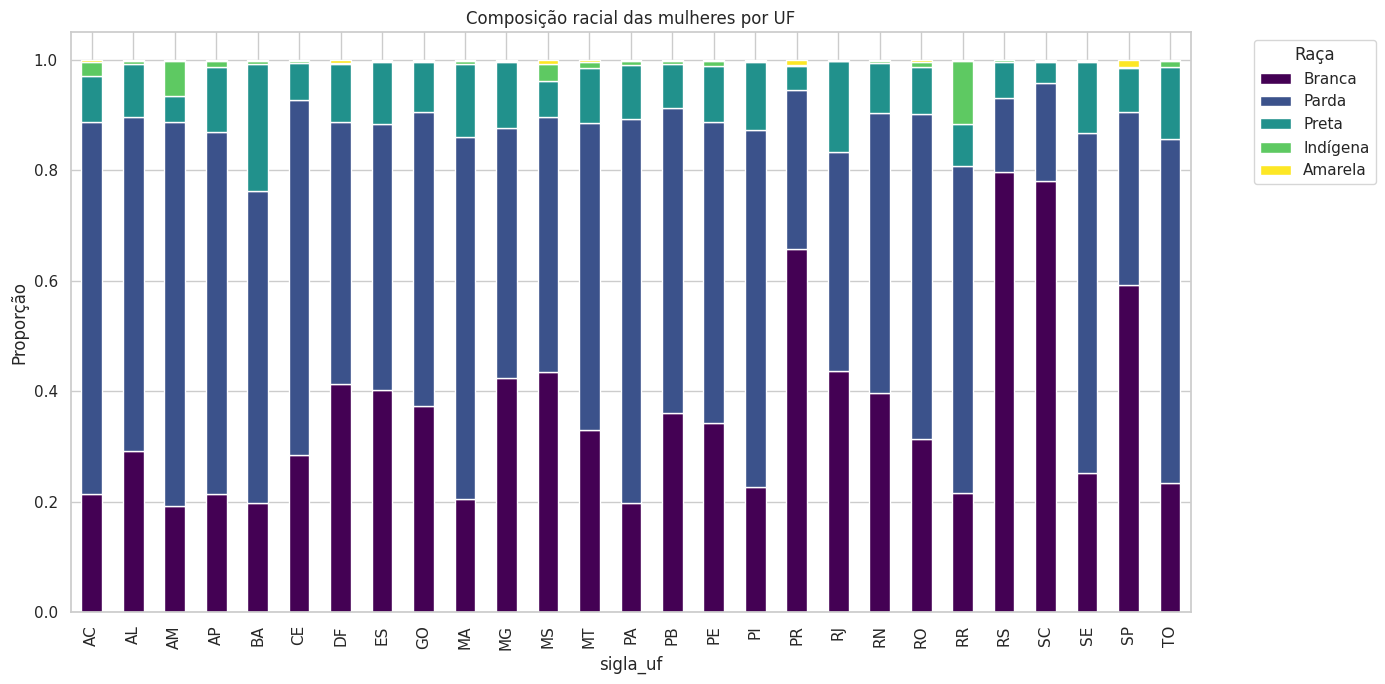

In [ ]:
pivot2 = pivot.copy()
pivot2 = pivot2.loc[:, ['Branca','Parda','Preta','Indígena','Amarela']]

pivot2.plot(kind='bar', stacked=True, figsize=(14,7), colormap='viridis')
plt.title("Composição racial das mulheres por UF")
plt.ylabel("Proporção")
plt.legend(title="Raça", bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


###  **CAPÍTULO 3 — Acesso à educação por raça (microdados da educação básica)**

Perguntas selecionadas:

. **A diferença de matrícula por raça é maior nos anos iniciais, finais do fundamental ou no ensino médio?**
. **Existe diferença racial na trajetória educacional feminina ao longo dos níveis?**

**Objetivo:**
Mostrar que a desigualdade *começa antes* da alfabetização.
Explicar caminhos educacionais desiguais.

####  **A diferença de matrícula por raça é maior nos anos iniciais, finais do fundamental ou no ensino médio?**

As desigualdades raciais tornam-se novamente evidentes quando examino os dados de matrículas do INEP.

Observei que a população autodeclarada parda representa a maioria das matrículas (oscilando entre 47% e 52%), um dado que espelha o próprio padrão demográfico da população brasileira.

No entanto, ao analisar a trajetória escolar, identifiquei comportamentos distintos entre brancos e pretos:

População Branca: Apresenta uma maior representatividade no início do ciclo escolar (47%), mas a sua participação cai para 42% no Ensino Médio, indicando uma redução na sua presença proporcional ao longo dos anos.

População Preta: Diferentemente do grupo anterior, notei que este grupo mantém uma estabilidade na sua representação percentual desde os anos iniciais até ao Ensino Médio."


In [53]:
# dicionário de raças (mesma sua)
raca_map = {
    'Branca': 'QT_MAT_BAS_BRANCA',
    'Preta': 'QT_MAT_BAS_PRETA',
    'Parda': 'QT_MAT_BAS_PARDA',
    'Amarela': 'QT_MAT_BAS_AMARELA',
    'Indígena': 'QT_MAT_BAS_INDIGENA'
}

# níveis já definidos (nome -> coluna com total de matrículas no nível)
niveis = {
    'Infantil': 'mat_inf',
    'Fund_AI': 'mat_fund_ai',
    'Fund_AF': 'mat_fund_af',
    'Medio': 'mat_med'
}

# 1) Construir tabela agregada: matrículas estimadas por nível x raça (somatório por todo o dataframe)
# Se você já criou colunas como 'Infantil_Branca' via pct * total, pule essa etapa e use-as diretamente.
est = {}
for nivel, col_nivel in niveis.items():
    # somar por raça: usar a distribuição racial (pct_<raca>) se existirem, senão aplicar fallback via proporção direta
    row = {}
    for raca in raca_map.keys():
        col_est = f"{nivel}_{raca}"
        if col_est in df.columns:
            valor = df[col_est].sum()
        else:
            # fallback: aplicar proporção racial do baseline (pct_<raca>) ao total do nível
            pct_col = f"pct_{raca}"
            if pct_col in df.columns:
                valor = (df[col_nivel] * df[pct_col]).sum()
            else:
                # último recurso: usar a coluna de matrículas básicas por raça proporcionalmente
                base_col = raca_map[raca]
                total_base = df[base_col].sum()
                total_bas = df[list(raca_map.values())].sum(axis=1).sum()
                prop = (total_base / total_bas) if total_bas > 0 else 0
                valor = df[col_nivel].sum() * prop
        row[raca] = valor
    est[nivel] = row

# 2) transformar em DataFrame (níveis x raças)
df_niveis_raca = pd.DataFrame.from_dict(est, orient='index').fillna(0)
df_niveis_raca.index.name = 'nivel'
# ex: df_niveis_raca.loc['Infantil','Branca'] -> matrículas estimadas de Brancas na Infantil

# 3) calcular métricas de desigualdade por nível
results = []
for nivel in df_niveis_raca.index:
    vals = df_niveis_raca.loc[nivel].values.astype(float)
    maior = vals.max()
    menor = vals.min()
    range_abs = maior - menor
    razao = maior / menor if menor > 0 else np.nan
    mean = vals.mean() if len(vals)>0 else np.nan
    range_rel = range_abs / mean if (mean and mean>0) else np.nan

    # Gini opcional (se weighted_gini estiver definido)
    try:
        # usar pesos iguais (ou usar valores das populações se você tiver)
        gini = weighted_gini(vals, np.ones_like(vals))
    except Exception:
        gini = np.nan

    results.append({
        'nivel': nivel,
        'maior_matricula_racial': maior,
        'menor_matricula_racial': menor,
        'desigualdade_range_abs': range_abs,
        'desigualdade_razao': razao,
        'desigualdade_range_rel': range_rel,
        'gini': gini
    })

df_desigualdade_niveis = pd.DataFrame(results).set_index('nivel').sort_values('desigualdade_range_abs', ascending=False)

# Converter matrículas absolutas para proporção dentro do nível
df_niveis_raca_pct = df_niveis_raca.div(df_niveis_raca.sum(axis=1), axis=0) * 100
df_niveis_raca_pct = df_niveis_raca_pct.round(2)

print("Matriz em % (níveis x raças):")
display(df_niveis_raca_pct)



Matriz em % (níveis x raças):


,Branca,Preta,Parda,Amarela,Indígena
nivel,,,,,
Infantil,47.00,4.45,47.20,0.47,0.89
Fund_AI,43.48,4.38,50.63,0.45,1.07
Fund_AF,42.07,4.45,52.07,0.45,0.95
Medio,42.66,5.21,50.86,0.53,0.73
